In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%%capture
!pip install transformers
!pip install -U adapter-transformers
!pip install datasets

In [3]:
# !git clone https://github.com/masakhane-io/masakhane-pos.git

In [4]:
from transformers import AutoTokenizer, AutoModelForMaskedLM
from transformers import AdamW
from transformers.adapters.configuration import PfeifferInvConfig
from preprocessing import preprocess_txt_file, preprocess_test_file
from tqdm.notebook import tqdm
import torch
import os
from IPython.display import clear_output
import matplotlib.pyplot as plt
import random
import numpy as np
from datasets import load_metric

In [5]:
tokenizer = AutoTokenizer.from_pretrained("Davlan/afro-xlmr-base")
model = AutoModelForMaskedLM.from_pretrained("Davlan/afro-xlmr-base")

In [6]:
accent = "luo"

In [7]:
def set_seed(args):
    """Set seed for training"""
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    if args.n_gpu > 0:
        torch.cuda.manual_seed_all(args.seed)

In [8]:
class AfriDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    def __getitem__(self, idx):
        return {key: val[idx].clone().detach() for key, val in self.encodings.items()}
    def __len__(self):
        return len(self.encodings.input_ids)

In [9]:
import pandas as pd
ss = pd.read_csv("Test.csv")
ss['new_sentence'] = ss['Id'].apply(lambda ch:int(ch.split('_')[-1])==0)
ss.drop(['Id', 'Pos'], axis=1, inplace=True)
ss.to_csv("submit.txt", sep=' ', header=None, index=False)

In [10]:
def get_data(accent):
    text = preprocess_test_file(accent)
    inputs = tokenizer(text[:500], return_tensors='pt', max_length=256, truncation=True, padding='max_length')
    inputs['labels'] = inputs.input_ids.detach().clone()
    rand = torch.rand(inputs.input_ids.shape)
    mask_arr = (rand < 0.15) * (inputs.input_ids != 0) * (inputs.input_ids != 2) * \
               (inputs.input_ids != 1) * (inputs.input_ids != 3)
    selection = []
    for i in range(inputs.input_ids.shape[0]):
        selection.append(torch.flatten(mask_arr[i].nonzero()).tolist())
    for i in range(inputs.input_ids.shape[0]):
        inputs.input_ids[i, selection[i]] = 250001
    train_dataset = AfriDataset(inputs)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)

    val_inputs = tokenizer(text[500:], return_tensors='pt', max_length=256, truncation=True, padding='max_length')
    val_inputs['labels'] = val_inputs.input_ids.detach().clone()
    val_rand = torch.rand(val_inputs.input_ids.shape)
    val_mask_arr = (val_rand < 0.15) * (val_inputs.input_ids != 0) * (val_inputs.input_ids != 2) * \
               (val_inputs.input_ids != 1) * (val_inputs.input_ids != 3)
    val_selection = []
    for i in range(val_inputs.input_ids.shape[0]):
        val_selection.append(torch.flatten(val_mask_arr[i].nonzero()).tolist())
    for i in range(val_inputs.input_ids.shape[0]):
        val_inputs.input_ids[i, val_selection[i]] = 250001
    val_dataset = AfriDataset(val_inputs)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False)
    return train_loader, selection, val_loader, val_selection

In [11]:
train_loader, train_selection, val_loader, val_selection = get_data(accent)

In [12]:
import argparse
parser = argparse.ArgumentParser()
args, _ = parser.parse_known_args()
args.seed = 42
args.n_gpu = 1
set_seed(args)

In [13]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
optim = AdamW(model.parameters(), lr=5e-4)
model_num_param = sum(p.numel() for p in model.parameters())
model_num_param

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


278295186

In [14]:
from transformers.adapters.configuration import AdapterConfig
lang_adapter_name = accent
adapter_non_linearity = "gelu"
adapter_reduction_factor = 4
leave_out = [len(model.roberta.encoder.layer)-1]

lang_adapter_config = "/content/drive/MyDrive/adapters-ibo/adapter_config.json"
load_lang_adapter = "/content/drive/MyDrive/adapters-ibo"

adapter_config = AdapterConfig.load(lang_adapter_config, non_linearity=adapter_non_linearity, reduction_factor=adapter_reduction_factor, leave_out=leave_out)
lang_adapter_name = model.load_adapter(load_lang_adapter, config=adapter_config, load_as=lang_adapter_name, with_head=False)

# adapter_config = PfeifferInvConfig(non_linearity=adapter_non_linearity, reduction_factor=adapter_reduction_factor, leave_out=leave_out)
# model.add_adapter(lang_adapter_name, config=adapter_config)

model.train_adapter([lang_adapter_name])
model.set_active_adapters([lang_adapter_name])
model.to(device)

XLMRobertaForMaskedLM(
  (shared_parameters): ModuleDict()
  (roberta): XLMRobertaModel(
    (shared_parameters): ModuleDict()
    (invertible_adapters): ModuleDict(
      (luo): NICECouplingBlock(
        (F): Sequential(
          (0): Linear(in_features=384, out_features=192, bias=True)
          (1): Activation_Function_Class(
            (f): GELUActivation()
          )
          (2): Linear(in_features=192, out_features=384, bias=True)
        )
        (G): Sequential(
          (0): Linear(in_features=384, out_features=192, bias=True)
          (1): Activation_Function_Class(
            (f): GELUActivation()
          )
          (2): Linear(in_features=192, out_features=384, bias=True)
        )
      )
    )
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elemen

In [15]:
epochs = 10
old_loss = 999999
model_adapter_num_param = sum(p.numel() for p in model.parameters())
model_adapter_num_param

281845842

In [16]:
print(f"Number of parameters of the model with adapter: {model_adapter_num_param:.0f}")
print(f"Number of parameters of the model without adapter: {model_num_param:.0f}")
print(f"Number of parameters of the adapter: {model_adapter_num_param - model_num_param:.0f}")
print(f"Pourcentage of additional parameters through adapter:",round(((model_adapter_num_param - model_num_param)/model_num_param)*100,2),'%')

Number of parameters of the model with adapter: 281845842
Number of parameters of the model without adapter: 278295186
Number of parameters of the adapter: 3550656
Pourcentage of additional parameters through adapter: 1.28 %


In [17]:
metric = load_metric("accuracy")

def compute_metrics(logits, labels, selection=None):
    predictions = np.argmax(logits, axis=-1)

    indices = [[i for i, x in enumerate(labels[row]) if x != 1] for row in range(len(labels))]
    if selection:
        labels = [labels[row][selection] for row in range(len(labels))]
        predictions = [predictions[row][selection] for row in range(len(predictions))]
    else:
        labels = [labels[row][indices[row]] for row in range(len(labels))]
        predictions = [predictions[row][indices[row]] for row in range(len(predictions))]

    labels = [item for sublist in labels for item in sublist]
    predictions = [item for sublist in predictions for item in sublist]

    results = metric.compute(predictions=predictions, references=labels)
    return results["accuracy"]

<ipython-input-17-e1e062760fe7>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [18]:
train_losses = []
val_losses = []
val_accuracies = []
lr = 5e-4
for epoch in range(epochs):
    model.train()
    losses = []
    train_loop = tqdm(train_loader, leave=True)
    for batch in train_loop:
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optim.step()
        train_loop.set_description(f'Epoch {epoch}')
        train_loop.set_postfix(loss=loss.item())
        losses.append(loss.item())
    avg_train_loss = sum(losses) / len(losses)
    train_losses.append(avg_train_loss)

    if epoch > 0:
        if loss.item() >= train_losses[-2]:
            lr = optim.param_groups[0]['lr']
            optim.param_groups[0]['lr'] /= 5
            print(f"Learning Rate : {lr} --> {optim.param_groups[0]['lr']}")
            lr = optim.param_groups[0]['lr']

    model.eval()
    losses = []
    acc = 0
    val_loop = tqdm(val_loader, leave=True)
    for i, batch in enumerate(val_loop):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        losses.append(loss.item())
        acc = acc * i + compute_metrics(outputs.logits.detach().cpu().numpy(), labels.detach().cpu().numpy(), val_selection[i])
        acc /= (i+1)
        val_loop.set_description('Evaluting')
        val_loop.set_postfix(loss=sum(losses)/len(losses), old_loss=old_loss, accuracy=acc)


    avg_val_loss = sum(losses) / len(losses)
    val_losses.append(avg_val_loss)

    if avg_val_loss >= old_loss:
        break
    old_loss = avg_val_loss
    val_accuracies.append(acc)
    if lr < 1e-7:
        break
    clear_output(wait=True)

  0%|          | 0/63 [00:00<?, ?it/s]

Learning Rate : 0.0001 --> 2e-05


  0%|          | 0/106 [00:00<?, ?it/s]

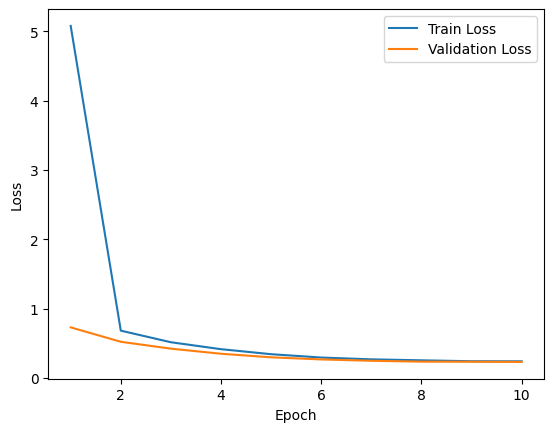

In [19]:
plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

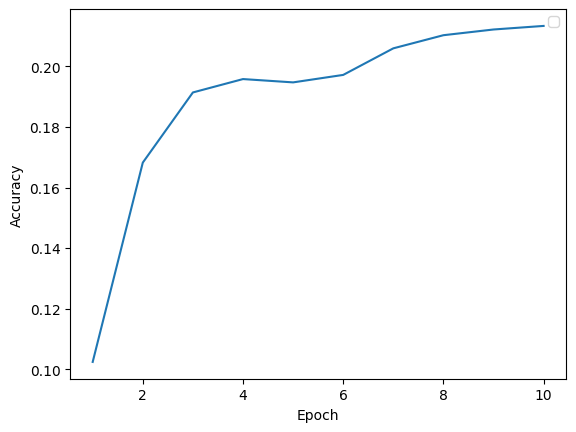

In [20]:
plt.plot(range(1, len(val_accuracies)+1), val_accuracies)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [21]:
adapters_folder = 'adapters-' + lang_adapter_name
model.save_adapter(adapters_folder, adapter_name=lang_adapter_name, with_head=False)

In [22]:
import shutil
destination_path = os.path.join("/content", "drive", "MyDrive", adapters_folder)
shutil.copytree(os.path.join("/content", adapters_folder), destination_path)

'/content/drive/MyDrive/adapters-luo'